In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as spr
import gurobipy as grb


data_X = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/Xvals.csv")
data_Y = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/Yvals.csv")
data_affmat = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/affinitymatrix.csv")

In [2]:
class random_panel:
    def __init__(self, init_matrix, time):
        self.time = time
        self.init_matrix = init_matrix
    def generate(self):
        X_panel = np.empty((self.time, self.init_matrix.shape[0], self.init_matrix.shape[1]))
        X_panel[0, :, :] = self.init_matrix
        for i in range(self.time - 1):
            X_panel[i+1, :, :] = X_panel[i, :, :] + np.random.randn(self.init_matrix.shape[0], self.init_matrix.shape[1])
        return X_panel
    
def matching_of_man(man, panel):
    for time in range(t):
        if np.all(panel[time, man-1, :]==0):
            print('Period', time+1, ': Single')
        else:
            print('Period', time+1, ': Woman', np.argwhere(panel[time, man-1,:] != 0)[0][0] + 1)
        
def matching_graph(panel):
    plt.rcParams["figure.figsize"] = (20, 6)
    matchings = np.empty((t, n))
    for time in range(t):
        matchings[time, :] = np.argwhere(panel[time, : ,:] != 0)[:, 1] + 1
    plt.plot(matchings)
    plt.show()

In [3]:
n = 100
t = 25

sdX = data_X.std().to_numpy()
sdY = data_Y.std().to_numpy()
mX = data_X.mean().to_numpy()
mY = data_Y.mean().to_numpy()

affmat = data_affmat.to_numpy()[0: 10, 1:]
Xvals = ((data_X-mX)/sdX).to_numpy()[0:n, :]
Yvals = ((data_Y-mY)/sdY).to_numpy()[0:n, :]
print('Xvals shape:', Xvals.shape)
print('Yvals shape:', Yvals.shape)
print('Affinity Matrix shape:', affmat.shape)

Xvals shape: (100, 10)
Yvals shape: (100, 10)
Affinity Matrix shape: (10, 10)


In [4]:
np.random.seed(42)

Xvals_dyna = random_panel(Xvals, t).generate()
Yvals_dyna = random_panel(Yvals.T, t).generate()
print(Xvals_dyna.shape)
print(Yvals_dyna.shape)

phi_dyna = Xvals_dyna @ affmat @ Yvals_dyna
print(phi_dyna.shape)

vecphi = phi_dyna.flatten()

(25, 100, 10)
(25, 10, 100)
(25, 100, 100)


# Perfectly competitive case

In [5]:
p = np.ones((t, n, 1))/n
q = np.ones((t, n, 1))/n
d = np.concatenate((p,q), axis = None)

sparse_one = spr.csr_matrix(np.ones(n).reshape(1, n))

A = spr.kron(spr.identity(n*t), sparse_one)
B = spr.kron(spr.kron(spr.identity(t), sparse_one), spr.identity(n))

Aconstr = spr.vstack([A, B])

m=grb.Model('Optimal Marriage')
x = m.addMVar(shape=t * n**2, name="x")
m.setObjective(vecphi @ x, grb.GRB.MAXIMIZE)
m.setParam('OutputFlag', False)
m.addConstr(Aconstr @ x == d, name="Constr")
m.optimize()

if m.status == grb.GRB.Status.OPTIMAL:
    pi_panel = np.array(m.getAttr('x')).reshape(t, n, n)
    pi_surplus = vecphi @ m.getAttr('x')
    
    
print('The total surplus obtained is: ', pi_surplus)

Academic license - for non-commercial use only - expires 2021-07-30
Using license file c:\gurobi911\gurobi.lic
The total surplus obtained is:  500.41251696613296


In [6]:
matching_of_man(1, pi_panel)

Period 1 : Woman 53
Period 2 : Woman 92
Period 3 : Woman 41
Period 4 : Woman 36
Period 5 : Woman 52
Period 6 : Woman 82
Period 7 : Woman 82
Period 8 : Woman 30
Period 9 : Woman 18
Period 10 : Woman 46
Period 11 : Woman 74
Period 12 : Woman 11
Period 13 : Woman 11
Period 14 : Woman 12
Period 15 : Woman 11
Period 16 : Woman 17
Period 17 : Woman 7
Period 18 : Woman 7
Period 19 : Woman 7
Period 20 : Woman 46
Period 21 : Woman 74
Period 22 : Woman 40
Period 23 : Woman 60
Period 24 : Woman 49
Period 25 : Woman 60


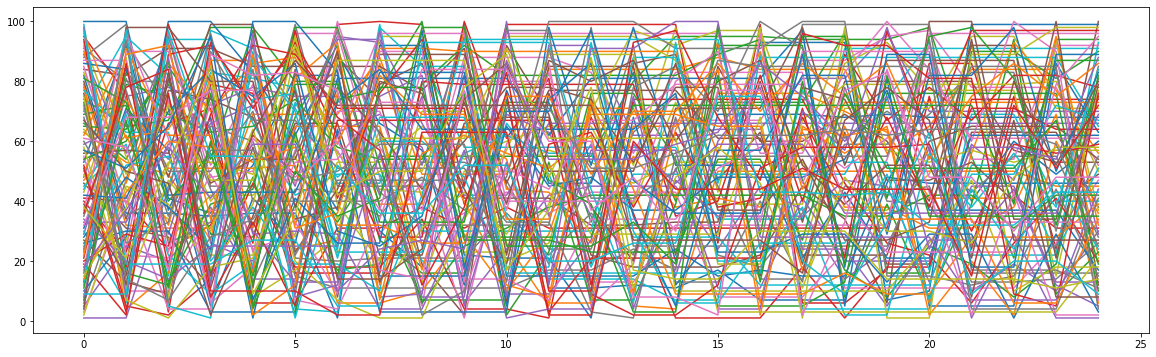

In [7]:
matching_graph(pi_panel)

# Fixed arbitrary reassignment cost case

In [8]:
reassignment_cost = 20
C = (pi_surplus/(t*n)) * reassignment_cost

phi_t = phi_dyna[0, :, :]
vecphi_t = phi_t.flatten()
p_t = np.ones((n, 1))/n
q_t = np.ones((n, 1))/n
d_t = np.concatenate((p_t, q_t), axis=None)

A_loop = spr.kron(sparse_one, spr.identity(n))
B_loop = spr.kron(spr.identity(n), sparse_one)
Aconstr_loop = spr.vstack([A_loop, B_loop])

pi_panel_loop = np.empty((t, n, n))
optimal_values_loop = []

for iteration in range(t):
    p = grb.Model('Optimal Coupling with reassignment cost')
    x = p.addMVar(shape = n**2, name = 'x')
    p.setObjective(vecphi_t @ x, grb.GRB.MAXIMIZE)
    p.addConstr(Aconstr_loop @ x == d_t)
    p.setParam('OutputFlag', False)
    p.optimize()
    if p.status == grb.GRB.Status.OPTIMAL:
        optimal_values_loop.append((phi_dyna[iteration, :, :]).flatten() @ p.getAttr('x'))
        matpi_t = np.array(p.getAttr('x')).reshape(n, n)
        pi_panel_loop[iteration, :, :] = matpi_t
    if iteration < t-1:
        vecphi_t = (phi_dyna[iteration+1, :, :] + (C * n * matpi_t)).flatten()
        
pi_loop_surplus = np.sum(optimal_values_loop)
welfare_loss_fixed = pi_surplus - pi_loop_surplus
print('With fixed reassignment cost multiplied by', reassignment_cost ,', the total welfare is', pi_loop_surplus, '\nIt is', (welfare_loss_fixed/pi_surplus)*100, '% lower than in the perfectly competitive case')

With fixed reassignment cost multiplied by 20 , the total welfare is 477.0599135363515 
It is 4.666670524422942 % lower than in the perfectly competitive case


In [9]:
matching_of_man(4, pi_panel_loop)

Period 1 : Woman 41
Period 2 : Woman 91
Period 3 : Woman 37
Period 4 : Woman 37
Period 5 : Woman 37
Period 6 : Woman 37
Period 7 : Woman 99
Period 8 : Woman 99
Period 9 : Woman 99
Period 10 : Woman 99
Period 11 : Woman 99
Period 12 : Woman 99
Period 13 : Woman 99
Period 14 : Woman 99
Period 15 : Woman 99
Period 16 : Woman 99
Period 17 : Woman 99
Period 18 : Woman 6
Period 19 : Woman 6
Period 20 : Woman 6
Period 21 : Woman 75
Period 22 : Woman 75
Period 23 : Woman 75
Period 24 : Woman 75
Period 25 : Woman 75


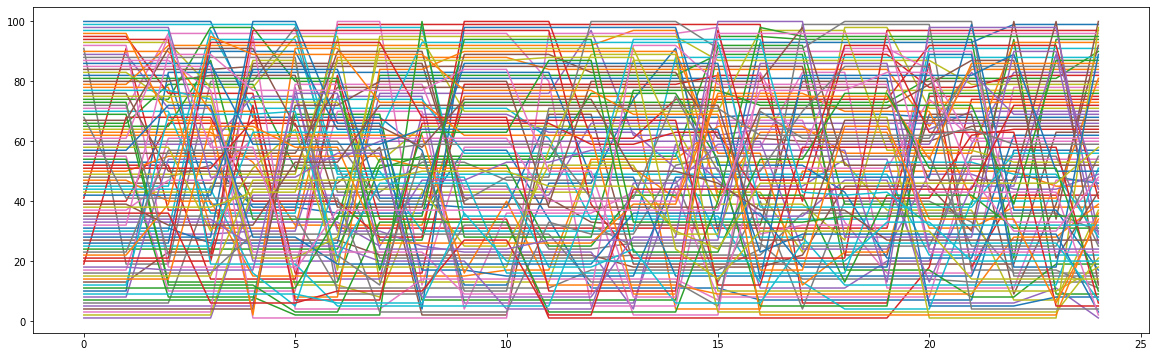

In [10]:
matching_graph(pi_panel_loop)

# Reassignment cost directly proportional to the surplus generated (solid couples remain)

In [11]:
reassignment_cost_prop = 20

C_prop = (pi_surplus/(t*n)) * reassignment_cost_prop

phi_t_prop = phi_dyna[0, :, :]
vecphi_t_prop = phi_t_prop.flatten()
p_t_prop = np.ones((n, 1))/n
q_t_prop = np.ones((n, 1))/n
d_t_prop = np.concatenate((p_t_prop, q_t_prop), axis=None)

A_loop_prop = spr.kron(sparse_one, spr.identity(n))
B_loop_prop = spr.kron(spr.identity(n), sparse_one)
Aconstr_loop_prop = spr.vstack([A_loop_prop, B_loop_prop])

pi_panel_loop_prop = np.empty((t, n, n))
optimal_values_loop_prop = []

for iteration_prop in range(t):
    q = grb.Model('Optimal Coupling with proportional reassignment cost')
    x_prop = q.addMVar(shape = n**2, name = 'x')
    q.setObjective(vecphi_t_prop @ x_prop, grb.GRB.MAXIMIZE)
    q.addConstr(Aconstr_loop_prop @ x_prop == d_t_prop)
    q.setParam('OutputFlag', False)
    q.optimize()
    if q.status == grb.GRB.Status.OPTIMAL:
        optimal_values_loop_prop.append((phi_dyna[iteration_prop, :, :]).flatten() @ q.getAttr('x'))
        matpi_t_prop = np.array(q.getAttr('x')).reshape(n, n)
        pi_panel_loop_prop[iteration_prop, :, :] = matpi_t_prop
    if iteration_prop < t-1:
        vecphi_t_prop = (phi_dyna[iteration_prop+1, :, :] + (C_prop * n * matpi_t_prop*phi_dyna[iteration_prop, :, :])).flatten()
        
pi_loop_surplus_prop = np.sum(optimal_values_loop_prop)
welfare_loss_prop = pi_surplus - pi_loop_surplus_prop
print('With proportional reassignment cost mutliplied by', reassignment_cost_prop,', the total welfare is', pi_loop_surplus_prop, '\nIt is', (welfare_loss_prop/pi_surplus)*100, '% lower than in the perfectly competitive case')

With proportional reassignment cost mutliplied by 20 , the total welfare is 323.20400717113523 
It is 35.41248545687175 % lower than in the perfectly competitive case


In [12]:
matching_of_man(1, pi_panel_loop_prop)

Period 1 : Woman 53
Period 2 : Woman 53
Period 3 : Woman 42
Period 4 : Woman 42
Period 5 : Woman 42
Period 6 : Woman 32
Period 7 : Woman 32
Period 8 : Woman 30
Period 9 : Woman 30
Period 10 : Woman 30
Period 11 : Woman 30
Period 12 : Woman 30
Period 13 : Woman 30
Period 14 : Woman 30
Period 15 : Woman 30
Period 16 : Woman 30
Period 17 : Woman 30
Period 18 : Woman 30
Period 19 : Woman 30
Period 20 : Woman 30
Period 21 : Woman 30
Period 22 : Woman 30
Period 23 : Woman 30
Period 24 : Woman 74
Period 25 : Woman 74


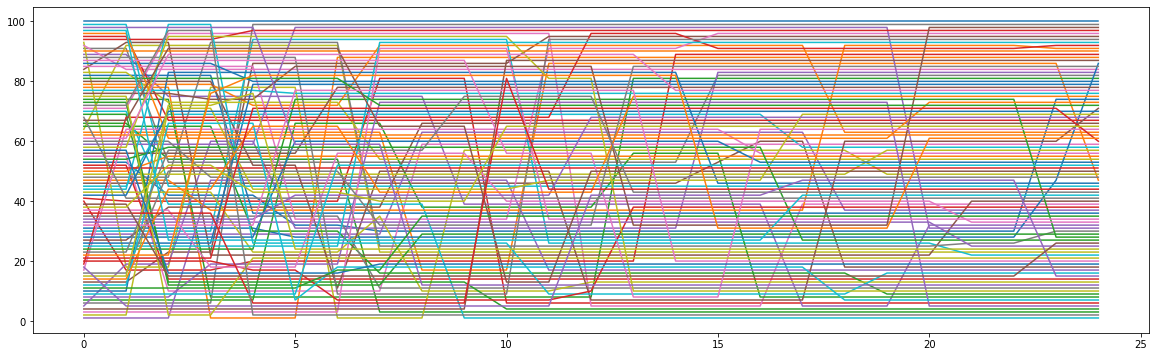

In [13]:
matching_graph(pi_panel_loop_prop)

# Optimal matching with unassigned agents

In [17]:
n = 10
t = 5

Xvals = ((data_X-mX)/sdX).to_numpy()[0:n, :]
Yvals = ((data_Y-mY)/sdY).to_numpy()[0:n, :]

np.random.seed(42)

Xvals_dyna = random_panel(Xvals, t).generate()
Yvals_dyna = random_panel(Yvals.T, t).generate()

phi_dyna = Xvals_dyna @ affmat @ Yvals_dyna
vecphi = phi_dyna.flatten()

sparse_one = spr.csr_matrix(np.ones(n).reshape(1, n))

p_s = np.ones((t, n, 1))/n
q_s = np.ones((t, n, 1))/n
d_s = np.concatenate((p_s,q_s), axis = None)

A_s = spr.kron(spr.identity(n*t), sparse_one)
B_s = spr.kron(spr.kron(spr.identity(t), sparse_one), spr.identity(n))

Aconstr_s = spr.vstack([A_s, B_s])

m_s=grb.Model('Optimal Marriage with unassigned agents')
x_s = m_s.addMVar(shape = t * n**2, name="x")
m_s.setObjective(vecphi @ x_s, grb.GRB.MAXIMIZE)
m_s.setParam('OutputFlag', False)
m_s.addConstr(Aconstr_s @ x_s <= d_s, name="Constr")
m_s.optimize()

if m_s.status == grb.GRB.Status.OPTIMAL:
    pi_panel_s = np.array(m_s.getAttr('x')).reshape(t, n, n)
    pi_surplus_s = vecphi @ m_s.getAttr('x')
    
    
print('The total surplus obtained is: ', pi_surplus_s, 'which is', 100*pi_surplus_s/pi_surplus, '% higher than in the case \nwhere all agents are assigned')

The total surplus obtained is:  13.695153168643763 which is 2.736772703383562 % higher than in the case 
where all agents are assigned


In [15]:
matching_of_man(1, pi_panel_s)

Period 1 : Woman 7
Period 2 : Woman 5
Period 3 : Woman 8
Period 4 : Woman 9
Period 5 : Single
